In [2]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False

import joblib

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.nn.pool import global_add_pool
from torch.utils.data import TensorDataset
from torch_geometric.utils import scatter
from torch_geometric.data import Batch
from torch.utils.data import Dataset
import random
# RDKit
import rdkit
from rdkit import Chem
import mordred
from mordred.Polarizability import APol, BPol
from mordred.TopoPSA import TopoPSA
from rdkit.Chem import rdMolDescriptors
print('Pytorch version:',torch.__version__)
print('Pytorch Geometric version:',torch_geometric.__version__)
print('RDKit version:', rdkit.__version__)
print('Mordred version:', mordred.__version__)
tqdm.pandas()


from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Binary
from pymoo.algorithms.moo.nsga2 import NSGA2 #, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.termination import get_termination
from pymoo.termination.max_gen import MaximumGenerationTermination

Pytorch version: 2.2.1+cpu
Pytorch Geometric version: 2.5.0
RDKit version: 2023.09.5
Mordred version: 1.2.0


In [3]:
# random seed for Python's random module
seed = 42
random.seed(seed)

# random seed for NumPy
np.random.seed(seed)

# random seed for PyTorch
torch.manual_seed(seed)

### Class to predict solubility

In [4]:
class PairDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
    def __len__(self):
        return len(self.datasetA)


class MPNNconv(nn.Module):
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats=32, num_step_message_passing=1):
        super(MPNNconv, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU()
        )

        self.num_step_message_passing = num_step_message_passing

        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats*node_out_feats)
        )
        self.gnn_layer = gnn.NNConv(
            node_out_feats,
            node_out_feats,
            edge_network,
            aggr='add'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)

    def reset_parameters(self):
        self.project_node_feats[0].reset_parameters()
        self.gnn_layer.reset_parameters()
        for layer in self.gnn_layer.edge_func:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, system_graph):

        node_feats = system_graph.x
        edge_index = system_graph.edge_index
        edge_feats = system_graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            if torch.cuda.is_available():
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor).cuda(),
                                                   edge_index=edge_index.type(torch.LongTensor).cuda(),
                                                   edge_attr=edge_feats.type(torch.FloatTensor).cuda()))
            else:
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor),
                                                   edge_index=edge_index.type(torch.LongTensor),
                                                   edge_attr=edge_feats.type(torch.FloatTensor)))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)
        return node_feats

class EdgeModel(torch.nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in*2 + e_in + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.edge_mlp = nn.Sequential(*layers)

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr, u[batch]], axis=1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self, v_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.node_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0), reduce='sum')
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp(out)

class GlobalModel(torch.nn.Module):
    def __init__(self, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(hidden_dim + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.global_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        node_aggregate = scatter(x, batch, dim=0, reduce='sum')
        edge_aggregate = scatter(edge_attr, batch[edge_index[1]], dim=0, reduce='sum')
        out = torch.cat([u, node_aggregate, edge_aggregate], dim=1)
        return self.global_mlp(out)

class GHGNN(nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim, n_extra_inputs):
        super(GHGNN, self).__init__()
        self.graphnet1 = gnn.MetaLayer(EdgeModel(v_in, e_in, u_in, hidden_dim),
                                      NodeModel(v_in, u_in, hidden_dim),
                                      GlobalModel(u_in, hidden_dim))
        self.graphnet2 = gnn.MetaLayer(EdgeModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim),
                                      NodeModel(hidden_dim, hidden_dim, hidden_dim),
                                      GlobalModel(hidden_dim, hidden_dim))

        self.gnorm1 = gnn.GraphNorm(hidden_dim)
        self.gnorm2 = gnn.GraphNorm(hidden_dim)

        self.pool = global_add_pool

        self.global_conv1 = MPNNconv(node_in_feats=hidden_dim*2,
                                     edge_in_feats=1,
                                     node_out_feats=hidden_dim*2)

        # MLP
        self.mlp1 = nn.Linear(hidden_dim*4 + n_extra_inputs, hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim, hidden_dim)
        self.mlp3 = nn.Linear(hidden_dim, 1)

    def generate_sys_graph(self, x, edge_attr, batch_size, n_mols=2):

        src = np.arange(batch_size)
        dst = np.arange(batch_size, n_mols*batch_size)

        self_connection = np.arange(n_mols*batch_size)

        # Biderectional connections (between each molecule in the system)
        # and self-connection
        one_way = np.concatenate((src, dst, self_connection))
        other_way = np.concatenate((dst, src, self_connection))
        edge_index = torch.tensor([list(one_way),
                                   list(other_way)], dtype=torch.long)
        sys_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return sys_graph

    def forward(self, c1, c2):
        # ---- Atomic polarizability
        ap1 = c1.ap.reshape(-1,1)
        ap2 = c2.ap.reshape(-1,1)

        # ---- Bond polarizability
        bp1 = c1.bp.reshape(-1,1)
        bp2 = c2.bp.reshape(-1,1)

        # -- Polarity via topological polar surface area
        topopsa1 = c1.topopsa.reshape(-1,1)
        topopsa2 = c2.topopsa.reshape(-1,1)

        # -- Hydrogen-bond acidity and basicity
        intra_hb1 = c1.inter_hb
        intra_hb2 = c2.inter_hb

        u1 = torch.cat((ap1,bp1,topopsa1), axis=1) # Molecular descriptors molecule 1
        u2 = torch.cat((ap2,bp2,topopsa2), axis=1) # Molecular descriptors molecule 2

        # Molecule 1 GraphNet
        x1, edge_attr1, u1 = self.graphnet1(c1.x, c1.edge_index, c1.edge_attr, u1, c1.batch)
        x1 = self.gnorm1(x1, c1.batch)
        x1, edge_attr1, u1 = self.graphnet2(x1, c1.edge_index, edge_attr1, u1, c1.batch)
        x1 = self.gnorm2(x1, c1.batch)
        xg1 = self.pool(x1, c1.batch)

        # Molecule 2 GraphNet
        x2, edge_attr2, u2 = self.graphnet1(c2.x, c2.edge_index, c2.edge_attr, u2, c2.batch)
        x2 = self.gnorm1(x2, c2.batch)
        x2, edge_attr2, u2 = self.graphnet2(x2, c2.edge_index, edge_attr2, u2, c2.batch)
        x2 = self.gnorm2(x2, c2.batch)
        xg2 = self.pool(x2, c2.batch)

        batch_size = c1.y.shape[0]

        # Intermolecular descriptors
        # -- Hydrogen bonding
        inter_hb  = c1.inter_hb
        # Construct binary system graph
        node_feat = torch.cat((
            torch.cat((xg1, u1), axis=1),
            torch.cat((xg2, u2), axis=1)),axis=0)
        edge_feat = torch.cat((inter_hb.repeat(2),
                               intra_hb1,
                               intra_hb2)).unsqueeze(1)
        binary_sys_graph = self.generate_sys_graph(x=node_feat,
                                                   edge_attr=edge_feat,
                                                   batch_size=batch_size)
        xg = self.global_conv1(binary_sys_graph)


        xg = torch.cat((xg[0:len(xg)//2,:], xg[len(xg)//2:,:]), axis=1)

        T = torch.reshape(c1.Temp,(-1,1))
        P = torch.reshape(c2.P,(-1,1))
        x1 = torch.reshape(c1.mol_x,(-1,1))
        x2 = torch.reshape(c2.mol_x,(-1,1))

        ExtraVar = torch.cat((T,P,x1,x2),1)
        x = torch.cat((xg,ExtraVar),1)
        x = F.sigmoid(self.mlp1(x))
        x = F.sigmoid(self.mlp2(x))
        x = self.mlp3(x)
        return x

class GNN_MG_sol(nn.Module):

    def __init__(self, model_name):
        " model is a string, example GNN_MG_sol.pth"
        super(GNN_MG_sol, self).__init__()
        self.model_name = model_name
        self.model = None
        self.naf = None
        self.nbf = None

    def load_model(self):
        device = 'cpu'
        naf, nbf = self.n_atom_features(), self.n_bond_features()
        model = GHGNN(naf, nbf, 3, 25, 4).to(device)
        checkpoint = torch.load(self.model_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model
        print('Succesfully loaded the model')

    def one_of_k_encoding(self, x, allowable_set):
        #print(x, allowable_set)
        if x not in allowable_set:
            raise Exception("input {0} not in allowable set{1}:".format(
                x, allowable_set))
        return list(map(lambda s: x == s, allowable_set))

    def n_atom_features(self):
        atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
        return len(self.atom_features(atom))

    def n_bond_features(self):
        bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
        return len(self.bond_features(bond))

    def atom_features(self,atom_k):
        '''
        Get atom features
        '''
        possible_atom_list = ['C','O','N','Cl','Br','P',]
        possible_hybridization = [Chem.rdchem.HybridizationType.SP,Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3]
        possible_num_bonds = [0,1,2,3,4]
        possible_formal_charge = [0,1,-1]
        possible_num_Hs  = [0,1,2,3]

        Symbol       = atom_k.GetSymbol()
        #print(Symbol,possible_atom_list)
        Type_atom     = self.one_of_k_encoding(Symbol, possible_atom_list)
        Ring_atom     = [atom_k.IsInRing()]
        Aromaticity   = [atom_k.GetIsAromatic()]
        Hybridization = self.one_of_k_encoding(atom_k.GetHybridization(), possible_hybridization)
        Bonds_atom    = self.one_of_k_encoding(len(atom_k.GetNeighbors()), possible_num_bonds)
        Formal_charge = self.one_of_k_encoding(atom_k.GetFormalCharge(), possible_formal_charge)
        num_Hs        = self.one_of_k_encoding(atom_k.GetTotalNumHs(), possible_num_Hs)

        results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
        Formal_charge + num_Hs
        return np.array(results).astype(np.float32)

    def bond_features(self,bond_k):
        bt = bond_k.GetBondType()
        # Features
        bond_feats = [
            bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
            bond_k.GetIsConjugated(),
            bond_k.IsInRing()]
        return np.array(bond_feats).astype(np.float32)

    def collate(self, data_list):
        batchA = Batch.from_data_list([data[0] for data in data_list])
        batchB = Batch.from_data_list([data[1] for data in data_list])
        return batchA, batchB

    
    def get_bond_pair(self, mol):
        bonds = mol.GetBonds()
        res = [[], []]
        for bond in bonds:
            res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
            res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
        return res

    def process_component(self,comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = self.get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([self.bond_features(bond)] * 2)
        return edge_attr, edge_index

    def info2graph(self,node_feat, edge_indx, edge_attr, y):
        """Creates graph for a component including the intra- and inter-molecular information"""
        nodes_info = torch.tensor(np.array(node_feat), dtype=torch.float32)
        edges_indx = torch.tensor(np.array(edge_indx), dtype=torch.long)
        edges_info = torch.tensor(np.array(edge_attr), dtype=torch.float32)
        graph = Data(x=nodes_info, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph_indiv(self, c1, c2, y_val = 0):
        """Helper function to create individual graphs."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [self.atom_features(atom_) for atom_ in atoms_c1]
        node_features_c2 = [self.atom_features(atom_) for atom_ in atoms_c2]

        edge_attr_c1, edge_index_c1 = self.process_component(c1)
        edge_attr_c2, edge_index_c2 = self.process_component(c2)

        # Info to graphs
        graph_c1 = self.info2graph(node_features_c1, edge_index_c1, edge_attr_c1, y_val)
        graph_c2 = self.info2graph(node_features_c2, edge_index_c2, edge_attr_c2, y_val)

        return graph_c1, graph_c2

    def create_graphs_from_row(self,row, mol_column_1, mol_column_2):
        graph_c1, graph_c2 = self.create_graph_indiv(row[mol_column_1], row[mol_column_2])

        # Append extra information to the graphs
        for graph in [graph_c1, graph_c2]:
            graph.Temp = row['T_norm']
            graph.P = row['P_norm']
            graph.mol_x = row['r_HBA_norm'] if graph == graph_c1 else row['r_HBD_norm']
            graph.ap = row['ap_hba_norm'] if graph == graph_c1 else row['ap_hbd_norm']
            graph.bp = row['bp_hba_norm'] if graph == graph_c1 else row['bp_hbd_norm']
            graph.topopsa = row['topopsa_hba_norm'] if graph == graph_c1 else row['topopsa_hbd_norm']
            graph.hb = row['hb_hba_norm'] if graph == graph_c1 else row['hb_hbd_norm']
            graph.inter_hb = row['inter_hb_norm']

        return graph_c1, graph_c2

    def sys2graph(self, df, mol_column_1, mol_column_2, single_system=False):
        """
        Constructs graph representations of binary molecular systems.

        Parameters:
        df (pd.DataFrame): Input dataframe.
        mol_column_1 (str): Column name for the first component.
        mol_column_2 (str): Column name for the second component.
        target (str): Column name for the target variable.
        single_system (bool, optional): Whether to treat the dataframe as a single system.
        Returns:
        list: A list of graph objects.
        """
        graphs_c1, graphs_c2 = zip(*df.apply(self.create_graphs_from_row, axis=1, args=(mol_column_1, mol_column_2)))
        return graphs_c1, graphs_c2


    def predict_sol(self, graphs_c1, graphs_c2, shuffle=False, drop_last=False):
        pair_dataset = PairDataset(graphs_c1, graphs_c2)
        data_loader_test  = torch.utils.data.DataLoader(pair_dataset,  batch_size=1, shuffle=shuffle, drop_last=drop_last, collate_fn=self.collate) 
        self.model.eval()
        with torch.no_grad():
            for batch_x1, batch_x2 in data_loader_test:
                out = self.model(batch_x1, batch_x2 ).item()  
        return out




### Class to predict viscosity

In [5]:
class GNN_MG_vis(nn.Module):

    def __init__(self, model_name):
        " model is a string, example GNN_MG_vis.pth"
        super(GNN_MG_vis, self).__init__()
        self.model_name = model_name
        self.model = None
        self.naf = None
        self.nbf = None

    def load_model(self):
        device = 'cpu'
        naf, nbf = self.n_atom_features(), self.n_bond_features()
        model = GHGNN(naf, nbf, 3, 25, 4).to(device)
        checkpoint = torch.load(self.model_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model

    def one_of_k_encoding(self, x, allowable_set):
        if x not in allowable_set:
            raise Exception("input {0} not in allowable set{1}:".format(
                x, allowable_set))
        return list(map(lambda s: x == s, allowable_set))

    def n_atom_features(self):
        atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
        return len(self.atom_features(atom))

    def n_bond_features(self):
        bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
        return len(self.bond_features(bond))

    def atom_features(self,atom_k):
        '''
        Get atom features
        '''
        possible_atom_list = ['C','O','N','Cl','Br','P','Zn','Cr', 'S', 'F', 'K','Na']
        possible_hybridization = [Chem.rdchem.HybridizationType.S,Chem.rdchem.HybridizationType.SP,Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3]
        possible_num_bonds = [0,1,2,3,4]
        possible_formal_charge = [0,1,-1]
        possible_num_Hs  = [0,1,2,3, 4]

        Symbol       = atom_k.GetSymbol()
        Type_atom     = self.one_of_k_encoding(Symbol, possible_atom_list)
        Ring_atom     = [atom_k.IsInRing()]
        Aromaticity   = [atom_k.GetIsAromatic()]
        Hybridization = self.one_of_k_encoding(atom_k.GetHybridization(), possible_hybridization)
        Bonds_atom    = self.one_of_k_encoding(len(atom_k.GetNeighbors()), possible_num_bonds)
        Formal_charge = self.one_of_k_encoding(atom_k.GetFormalCharge(), possible_formal_charge)
        num_Hs        = self.one_of_k_encoding(atom_k.GetTotalNumHs(), possible_num_Hs)

        results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
        Formal_charge + num_Hs
        return np.array(results).astype(np.float32)

    def bond_features(self,bond_k):
        bt = bond_k.GetBondType()
        # Features
        bond_feats = [
            bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
            bond_k.GetIsConjugated(),
            bond_k.IsInRing()]
        return np.array(bond_feats).astype(np.float32)

    def collate(self, data_list):
        batchA = Batch.from_data_list([data[0] for data in data_list])
        batchB = Batch.from_data_list([data[1] for data in data_list])
        return batchA, batchB

    def get_bond_pair(self,mol):
        bonds = mol.GetBonds()
        res = [[], []]
        for bond in bonds:
            res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
            res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
        return res

    def process_component(self,comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = self.get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([self.bond_features(bond)] * 2)
        return edge_attr, edge_index

    def info2graph(self,node_feat, edge_indx, edge_attr, y):
        """Creates graph for a component including the intra- and inter-molecular information"""
        nodes_info = torch.tensor(np.array(node_feat), dtype=torch.float32)
        edges_indx = torch.tensor(np.array(edge_indx), dtype=torch.long)
        edges_info = torch.tensor(np.array(edge_attr), dtype=torch.float32)
        graph = Data(x=nodes_info, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph_indiv(self, c1, c2, y_val = 0):
        """Helper function to create individual graphs."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [self.atom_features(atom_) for atom_ in atoms_c1]
        node_features_c2 = [self.atom_features(atom_) for atom_ in atoms_c2]

        edge_attr_c1, edge_index_c1 = self.process_component(c1)
        edge_attr_c2, edge_index_c2 = self.process_component(c2)

        # Info to graphs
        graph_c1 = self.info2graph(node_features_c1, edge_index_c1, edge_attr_c1, y_val)
        graph_c2 = self.info2graph(node_features_c2, edge_index_c2, edge_attr_c2, y_val)

        return graph_c1, graph_c2

    def create_graphs_from_row(self,row, mol_column_1, mol_column_2):
        graph_c1, graph_c2 = self.create_graph_indiv(row[mol_column_1], row[mol_column_2])

        # Append extra information to the graphs
        for graph in [graph_c1, graph_c2]:
            graph.Temp = row['T_norm']
            graph.P = row['P_norm']
            graph.mol_x = row['r_HBA_norm'] if graph == graph_c1 else row['r_HBD_norm']
            graph.ap = row['ap_hba_norm'] if graph == graph_c1 else row['ap_hbd_norm']
            graph.bp = row['bp_hba_norm'] if graph == graph_c1 else row['bp_hbd_norm']
            graph.topopsa = row['topopsa_hba_norm'] if graph == graph_c1 else row['topopsa_hbd_norm']
            graph.hb = row['hb_hba_norm'] if graph == graph_c1 else row['hb_hbd_norm']
            graph.inter_hb = row['inter_hb_norm']

        return graph_c1, graph_c2

    def sys2graph(self, df, mol_column_1, mol_column_2, single_system=False):
        """
        Constructs graph representations of binary molecular systems.

        Parameters:
        df (pd.DataFrame): Input dataframe.
        mol_column_1 (str): Column name for the first component.
        mol_column_2 (str): Column name for the second component.
        target (str): Column name for the target variable.
        single_system (bool, optional): Whether to treat the dataframe as a single system.
        Returns:
        list: A list of graph objects.
        """
        graphs_c1, graphs_c2 = zip(*df.apply(self.create_graphs_from_row, axis=1, args=(mol_column_1, mol_column_2)))
        return graphs_c1, graphs_c2



    def predict_vis(self, graphs_c1, graphs_c2, shuffle=False, drop_last=False):
        pair_dataset = PairDataset(graphs_c1, graphs_c2)
        data_loader_test  = torch.utils.data.DataLoader(pair_dataset,  batch_size=1, shuffle=shuffle, drop_last=drop_last, collate_fn=self.collate) 
        self.model.eval()
        with torch.no_grad():
            for batch_x1, batch_x2 in data_loader_test:
                out = self.model(batch_x1, batch_x2 ).item()  
        return out


In [39]:

class Deep_Eutectic_Solvent_Desing(ElementwiseProblem):
    
    def __init__(self, len_HBA, len_HBD, r_HBA_max, r_HBD_max, Temp_max, Pressure_max, df_hba, df_hbd,
                    model_sol, model_vis, **kwargs):
        variables = dict()
        self.len_HBA = len_HBA
        self.len_HBD = len_HBD
        self.r_HBA_max =  r_HBA_max
        self.r_HBD_max =  r_HBD_max
        self.Temp_max  = Temp_max
        self.Pressure_max = Pressure_max 
        self.df_hba = df_hba
        self.df_hbd = df_hbd
        self.model_sol = model_sol
        self.model_vis = model_vis
        self.T, self.P, self.r_HBA ,self.r_HBD = 273.15,150,1,1
        self.features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
        self.norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
        # ------------------Bounds----------------------#
        variables[f"y1"] = Integer(bounds=(0,self.len_HBA))     #Position HBA
        variables[f'y2'] = Integer(bounds=(0,self.len_HBD))     #Position HBD
        variables[f'y3'] = Integer(bounds=(1,self.r_HBA_max))      # r_HBA
        variables[f'y4'] = Integer(bounds=(1,self.r_HBD_max))      # r_HBD
        variables[f'y5'] = Real(bounds=(293.15,self.Temp_max))       #Temperature
        variables[f'y6'] = Real(bounds=(26.3,self.Pressure_max))   #Pressure  kPa
        super().__init__(vars=variables, n_obj=2,n_ieq_constr=0, **kwargs)

    def constraints_eval(self, pos_hba, pos_hbd ):
        Constraint_List = []
        Constraint_List.append(self.df_hba.iloc[pos_hba,2] == self.df_hbd.iloc[pos_hbd,2] ) 
        return Constraint_List

    def penalty_function(self):
        return 15, 15
   
    def get_hb_sites(self, mol):
        return min(rdMolDescriptors.CalcNumHBA(mol), rdMolDescriptors.CalcNumHBD(mol))

    def get_inter_hb_sites(self, row):
        mol1 = row['mol_hba']
        mol2 = row['mol_hbd']
        return min(rdMolDescriptors.CalcNumHBA(mol1), rdMolDescriptors.CalcNumHBD(mol2)) + \
            min(rdMolDescriptors.CalcNumHBA(mol2), rdMolDescriptors.CalcNumHBD(mol1))

    def get_point_solubility(self,pos_hba,pos_hbd):
        #print('Abre')
        list = np.array([[self.df_hba.iloc[pos_hba,2],self.df_hbd.iloc[pos_hbd,2]]])  # get smiles only
        #print(list)
        df = pd.DataFrame(list, columns= ['HBA_SMILES', 'HBD_SMILES'])
        df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
        df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)
        df['ap_hba'] = df['mol_hba'].apply(APol())
        df['ap_hbd'] = df['mol_hbd'].apply(APol())
        df['bp_hba'] = df['mol_hba'].apply(BPol())
        df['bp_hbd'] = df['mol_hbd'].apply(BPol())
        df['topopsa_hba'] = df['mol_hba'].apply(TopoPSA())
        df['topopsa_hbd'] = df['mol_hbd'].apply(TopoPSA()) 
        df['inter_hb'] = df.apply(self.get_inter_hb_sites, axis=1)
        df['hb_hba'] = df['mol_hba'].apply(self.get_hb_sites)
        df['hb_hbd'] = df['mol_hbd'].apply(self.get_hb_sites)
        df['T (K)'] = self.T
        df['P (kPa)'] = self.P
        df['r HBA'] = self.r_HBA
        df['r HBD'] = self.r_HBD

        std_scl_sol = joblib.load('std_scaler_sol.bin')

        X_data = df[self.features].values
        X_norm = std_scl_sol.transform(X_data)
        df[self.norm_feature_names] = X_norm
        g_hba_lst, g_hbd_lst = self.model_sol.sys2graph(df, 'mol_hba', 'mol_hbd')
        df['g_hba'] = g_hba_lst
        df['g_hbd'] = g_hbd_lst
        g1s = [df['g_hba'].iloc[0]] 
        g2s = [df['g_hbd'].iloc[0]]  
        sol = self.model_sol.predict_sol(g1s,g2s)
        return sol 

    def get_point_viscosity(self,pos_hba,pos_hbd):
        list = np.array([[self.df_hba.iloc[pos_hba,2],self.df_hbd.iloc[pos_hbd,2]]])  # get smiles only
        df = pd.DataFrame(list, columns= ['HBA_SMILES', 'HBD_SMILES'])
        df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
        df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)
        df['ap_hba'] = df['mol_hba'].apply(APol())
        df['ap_hbd'] = df['mol_hbd'].apply(APol())
        df['bp_hba'] = df['mol_hba'].apply(BPol())
        df['bp_hbd'] = df['mol_hbd'].apply(BPol())
        df['topopsa_hba'] = df['mol_hba'].apply(TopoPSA())
        df['topopsa_hbd'] = df['mol_hbd'].apply(TopoPSA()) 
        df['inter_hb'] = df.apply(self.get_inter_hb_sites, axis=1)
        df['hb_hba'] = df['mol_hba'].apply(self.get_hb_sites)
        df['hb_hbd'] = df['mol_hbd'].apply(self.get_hb_sites)
        df['T (K)'] = self.T
        df['P (kPa)'] = 0  # Viscosity is independent of pressure in the dataset
        df['r HBA'] = self.r_HBA/ (self.r_HBA + self.r_HBD)  # The model was trained with molar fractions, so its neccesary to convert it 
        df['r HBD'] = self.r_HBD/ (self.r_HBA + self.r_HBD)  # The model was trained with molar fractions, so its neccesary to convert it 

        std_scl_vis = joblib.load('std_scaler_vis.bin')

        X_data = df[self.features].values
        X_norm = std_scl_vis.transform(X_data)
        df[self.norm_feature_names] = X_norm
        g_hba_lst, g_hbd_lst = self.model_vis.sys2graph(df, 'mol_hba', 'mol_hbd')
        df['g_hba'] = g_hba_lst
        df['g_hbd'] = g_hbd_lst
        g1s = [df['g_hba'].iloc[0]] 
        g2s = [df['g_hbd'].iloc[0]]  
        vis = self.model_vis.predict_vis(g1s,g2s)
        return vis 

    
    def _evaluate(self, y, out, *args, **kwargs):
        y = np.array([y[f"y{k:01}"] for k in range(1,7)])
        #print(y)
        # Get position of HBA and HBD 
        pos_hba,pos_hbd = int(y[0]-1), int(y[1]-1)
        #----------Constraints function----------#
        cnst = self.constraints_eval(pos_hba, pos_hbd)
        #print('cnst',cnst)
        if all(cnst) == True : # If HBA is the same as HBD ..
            sol, vis = self.penalty_function()
        else:
            # Update the values of r_HBA, HBD. T and P
            self.r_HBA,self.r_HBD ,self.T,self.P= y[2], y[3], y[4], y[5]
            sol = self.get_point_solubility(pos_hba,pos_hbd) * -1
            vis = self.get_point_viscosity(pos_hba,pos_hbd)
        #print(sol,vis)
        out["F"] = [sol, vis]             #Declare the functions
        out["G"] = []                      #Declare the constraints


In [22]:
df_hba = pd.read_csv('HBA_smiles_sol.csv')
df_hbd = pd.read_csv('HBD_smiles_sol.csv')
print('Nunber of HBA', df_hba.shape)
print('Nunber of HBD', df_hbd.shape)

Nunber of HBA (24, 3)
Nunber of HBD (26, 3)


In [99]:
df_hba = pd.read_csv('HBA_smiles_sol.csv')
df_hbd = pd.read_csv('HBD_smiles_sol.csv')

model_sol = GNN_MG_sol('GNN_MG_sol.pth')
model_sol.load_model()
model_vis = GNN_MG_vis('GNN_MG_vis.pth')
model_vis.load_model()
problem = Deep_Eutectic_Solvent_Desing(len(df_hba['SMILES']),len(df_hbd['SMILES']), 1,  16,  348.15, 250, df_hba, df_hbd, model_sol, model_vis)  # max pressure 7620)

gen = 200
ofs = 30
pop = 100
# Define the number of generations 
termination = get_termination("n_gen", gen)

algorithm = NSGA2(pop_size=pop,  n_offsprings=ofs, sampling=MixedVariableSampling(),
                mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,algorithm,termination,seed=42,save_history=True,verbose=True)

Succesfully loaded the model
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      6 |             - |             -
     2 |      130 |      9 |  0.1412088678 |         ideal
     3 |      160 |     10 |  0.0137652876 |             f
     4 |      190 |      8 |  0.0275598478 |             f
     5 |      220 |      8 |  0.0052696508 |             f
     6 |      250 |      9 |  0.0477120467 |             f
     7 |      280 |      9 |  0.0043210491 |             f
     8 |      310 |     11 |  0.0038124660 |             f
     9 |      340 |     11 |  0.000000E+00 |             f
    10 |      370 |     12 |  0.0111449084 |             f
    11 |      400 |     13 |  0.0087086542 |             f
    12 |      430 |     13 |  0.000000E+00 |             f
    13 |      460 |     12 |  0.0047147921 |             f
    14 |      490 |      6 |  0.0359513507 |             f
    15 |      520 |      7 |  0.0106099227 |             f
    16 |      550 |      7 

# Save data 

In [100]:
sol, fun, const = [], [], []
for i , c in enumerate(res.history):
    sol.extend(c.pop.get("F"))
    fun.extend(c.pop.get("X"))
df1 = pd.DataFrame(data=sol , columns=['Solubiliti', 'Viscosity'])
df2 = pd.DataFrame(data=fun )
df =pd.concat([df1,df2], axis= 1)
df['Solubiliti'] = df['Solubiliti']*-1
df['HBA name'] = [ df_hba.iloc[c['y1']-1,0] for i, c in enumerate(fun) ]
df['HBD name'] = [ df_hbd.iloc[c['y2']-1,0] for i, c in enumerate(fun) ]
df['SMILE HBA'] = [ df_hba.iloc[c['y1']-1,2] for i, c in enumerate(fun) ]
df['SMILE HBD'] = [ df_hbd.iloc[c['y2']-1,2] for i, c in enumerate(fun) ]
df.to_csv('novel_deep_eutectic_solvents.csv', index=False) 


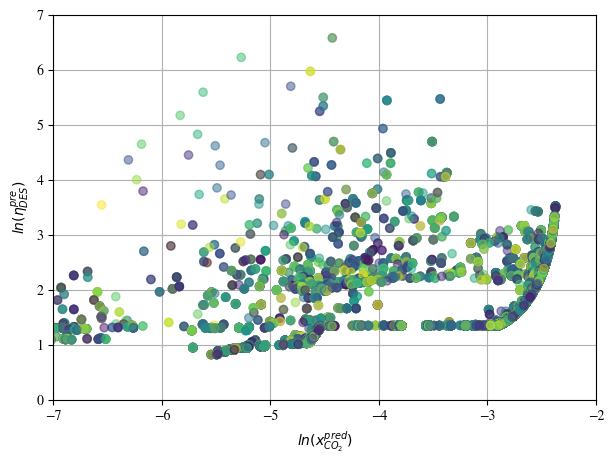

In [101]:
colors = np.random.rand(len(df['Solubiliti']))
plt.scatter(df['Solubiliti'], df['Viscosity'], c=colors, alpha=0.5)
plt.ylabel(r'$ln(\eta^{pre}_{DES}) $')
plt.xlabel(r'$ln(x^{pred}_{CO_2}) $')
plt.ylim([0,7])
plt.xlim([-7,-2])
plt.grid()
plt.show()